In [7]:
%matplotlib notebook
import pandas as pd
import numpy as np
from obspy.core.utcdatetime import UTCDateTime
import importlib
import matplotlib.pyplot as plt
import obspy
import os

from nbeats_keras.model import NBeatsNet as NBeatsKeras
#from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch

In [8]:
def create_one_obspy_trace(times, amp, balloon, starttime, dt,):
                        
    #f = interpolate.interp1d(times, amp, kind='linear', )
    #times_interp = np.arange(one_tec_data.epoch.values.min()*dt, one_tec_data.epoch.values.max()*dt+dt, dt)
    #vTEC = f(times_interp)
    tr = obspy.Trace()
    tr.data = amp
    tr.stats.delta = dt
    #tr.stats.network = station
    #tr.stats.station = satellite+'ZZZ'+station
    tr.stats.station = balloon
    tr.stats.starttime = starttime+times[0]
    return tr

def load_balloon_data(dir_data, starttimes, ):
    
    datas = {'GPS': obspy.Stream(), 'Baro': obspy.Stream()}
    for subdir, dirs, files in os.walk(dir_data):
        #print(files)
        for file in files:
            filepath = subdir + os.sep + file
            if not '.csv' in file:
                continue
                
            #if not 'Tortoise' in file:
            #    continue
            
            balloon = file.split('_')[0]
            if not balloon in starttimes.keys():
                continue
            print(balloon)
            
            data = pd.read_csv(filepath, header=[0])
            
            type_data = file.split('_')[1].split('.')[0]
            
            starttime = starttimes[balloon]
            times = data['GPSTime(s)'].values
            #if balloon == 'Tortoise':
            #    print(file)
            #    print(times/3600)
            dt = times[1]-times[0]
            #print(data.columns)
            try:
                amp = data['WGS84Altitude(m)'].values
            except:
                amp = data[data.columns[-1]].values
            tr_data = create_one_obspy_trace(times, amp, balloon, starttime, dt)
            datas[type_data] += tr_data
            
    return datas

starttimes = {
    #'Hare': UTCDateTime(2019, 7, 22),
    'Tortoise': UTCDateTime(2019, 7, 22),
    #'Hare2': UTCDateTime(2019, 8, 9),
    #'CrazyCatLower': UTCDateTime(2019, 8, 9),
    #'CrazyCatUpper': UTCDateTime(2019, 8, 9),
}
dir_data = '/projects/infrasound/data/infrasound/2023_ML_balloon/data/Siddharth_balloon/'
st_all = load_balloon_data(dir_data, starttimes,)

Tortoise
Tortoise


In [57]:
def subplots(outputs: dict, backend_name: str):
    layers = [a[0] for a in outputs.items()]
    values = [a[1] for a in outputs.items()]
    assert len(layers) == len(values)
    n = len(layers)
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(15, 3))
    plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.75, wspace=0.4, hspace=0.4)
    for i in range(n):
        axes[i].plot(values[i], color='deepskyblue')
        axes[i].set_title(layers[i])
        axes[i].set_xlabel('t')
        axes[i].grid(axis='x')
        axes[i].grid(axis='y')
    fig.suptitle(f'{backend_name} - Outputs of the generic and interpretable configurations', fontweight='bold')
    plt.draw()


def plot(target, generic_predictions, interpretable_predictions, backend_name):
    plt.figure()
    plt.plot(target, color='gold', linewidth=2)
    plt.plot(interpretable_predictions + generic_predictions, color='r', linewidth=2)
    plt.plot(interpretable_predictions, color='orange')
    plt.plot(generic_predictions, color='green')
    plt.grid()
    plt.legend(['ACTUAL', 'FORECAST-PRED', 'FORECAST-I', 'FORECAST-G'])
    plt.xlabel('t')
    plt.title(f'{backend_name} - Forecast - Actual vs Predicted')
    plt.draw()

backcast_length = 500
forecast_length = 20

"""
data_gen = dummy_data_generator(
    backcast_length=backcast_length, forecast_length=forecast_length,
    signal_type='seasonality', random=False, batch_size=32
)
num_samples_train = 1000
num_samples_test = 200
batches = list(itertools.islice(data_gen, num_samples_train))
x_train = np.vstack([b[0] for b in batches])
y_train = np.vstack([b[1] for b in batches])

batches = list(itertools.islice(data_gen, num_samples_test))
x_test = np.vstack([b[0] for b in batches])
y_test = np.vstack([b[1] for b in batches])
"""

freq_min=0.1
freq_max=5.
start_constant_alt = UTCDateTime('2019-07-22T14:09:00') +5000.# Tortoise
end_constant_alt = st_all['Baro'][0].stats.endtime # Tortoise
data = st_all['Baro'][0].copy()
data.filter('bandpass', freqmin=freq_min, freqmax=freq_max)
data.trim(starttime=start_constant_alt,endtime=end_constant_alt)
data.resample(5.)
# data backcast/forecast generation.
x, y = [], []
for epoch in range(backcast_length, len(data) - forecast_length):
    x.append(data[epoch - backcast_length:epoch])
    y.append(data[epoch:epoch + forecast_length])
x = np.array(x)
y = np.array(y)

# split train/test.
c = int(len(x) * 0.8)
x_train, y_train = x[:c], y[:c]
x_test, y_test = x[c:], y[c:]


# normalization.
norm_constant = np.max(x_train)
x_train, y_train = x_train / norm_constant, y_train / norm_constant
x_test, y_test = x_test / norm_constant, y_test / norm_constant


for backend in [NBeatsKeras]:
    backend_name = backend.name()
    print(f'Running the example for {backend_name}...')
    model = backend(
        backcast_length=backcast_length, forecast_length=forecast_length,
        #stack_types=(backend.GENERIC_BLOCK, backend.TREND_BLOCK, backend.SEASONALITY_BLOCK),
        stack_types=(backend.GENERIC_BLOCK, backend.GENERIC_BLOCK, backend.GENERIC_BLOCK),
        nb_blocks_per_stack=4, thetas_dim=(16, 16, 16), hidden_layer_units=20
    )
    model.compile(loss='mse', optimizer='adam')
    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15, batch_size=32)
    model.enable_intermediate_outputs()

Running the example for NBeatsKeras...
Epoch 1/15
1243/1243 [==============================] - 29s 10ms/step - loss: 0.0221 - val_loss: 0.0222
Epoch 2/15
1243/1243 [==============================] - 11s 9ms/step - loss: 0.0186 - val_loss: 0.0226
Epoch 3/15
1243/1243 [==============================] - 11s 9ms/step - loss: 0.0167 - val_loss: 0.0243
Epoch 4/15
1243/1243 [==============================] - 11s 9ms/step - loss: 0.0152 - val_loss: 0.0247
Epoch 5/15
1243/1243 [==============================] - 11s 9ms/step - loss: 0.0140 - val_loss: 0.0257
Epoch 6/15
1243/1243 [==============================] - 11s 9ms/step - loss: 0.0131 - val_loss: 0.0266
Epoch 7/15
1243/1243 [==============================] - 12s 9ms/step - loss: 0.0125 - val_loss: 0.0265
Epoch 8/15
1243/1243 [==============================] - 11s 9ms/step - loss: 0.0120 - val_loss: 0.0279
Epoch 9/15
1243/1243 [==============================] - 11s 9ms/step - loss: 0.0116 - val_loss: 0.0271
Epoch 10/15
1243/1243 [==========

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


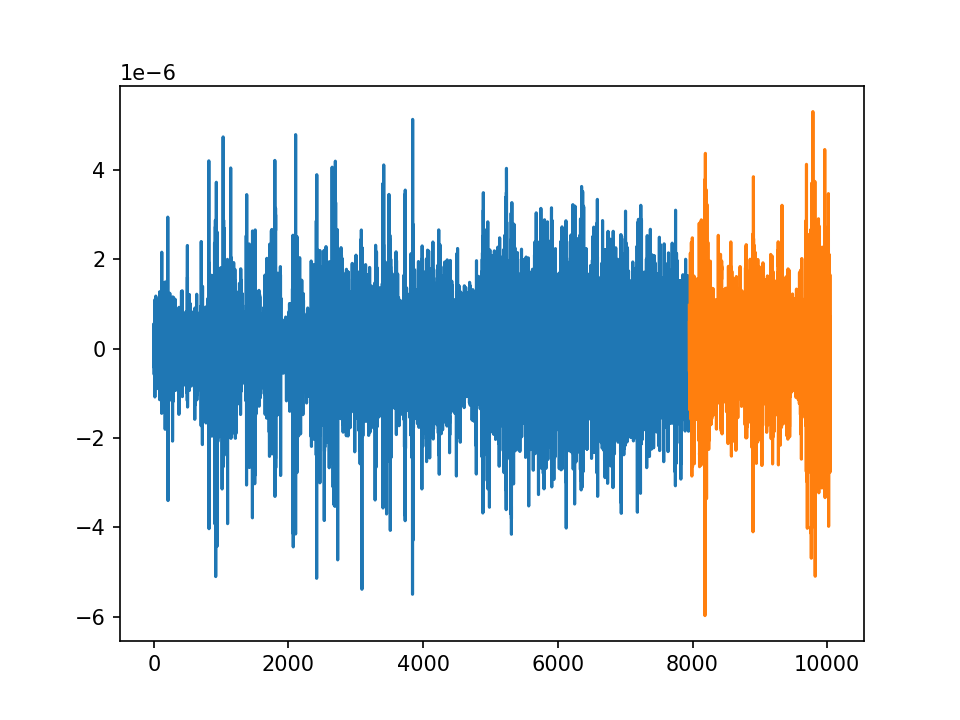

In [51]:
freq_min=0.1
freq_max=5.
start_constant_alt = UTCDateTime('2019-07-22T14:09:00')+5000. # Tortoise
end_constant_alt = st_all['Baro'][0].stats.endtime # Tortoise
data = st_all['Baro'][0].copy()
data.filter('bandpass', freqmin=freq_min, freqmax=freq_max)
data.trim(starttime=start_constant_alt,endtime=end_constant_alt)
data.resample(5.)

plt.figure()
plt.plot(data.times()[:c], data.data[:c])
plt.plot(data.times()[c:], data.data[c:])

1/1 [==============================] - 0s 32ms/step


<IPython.core.display.Javascript object>


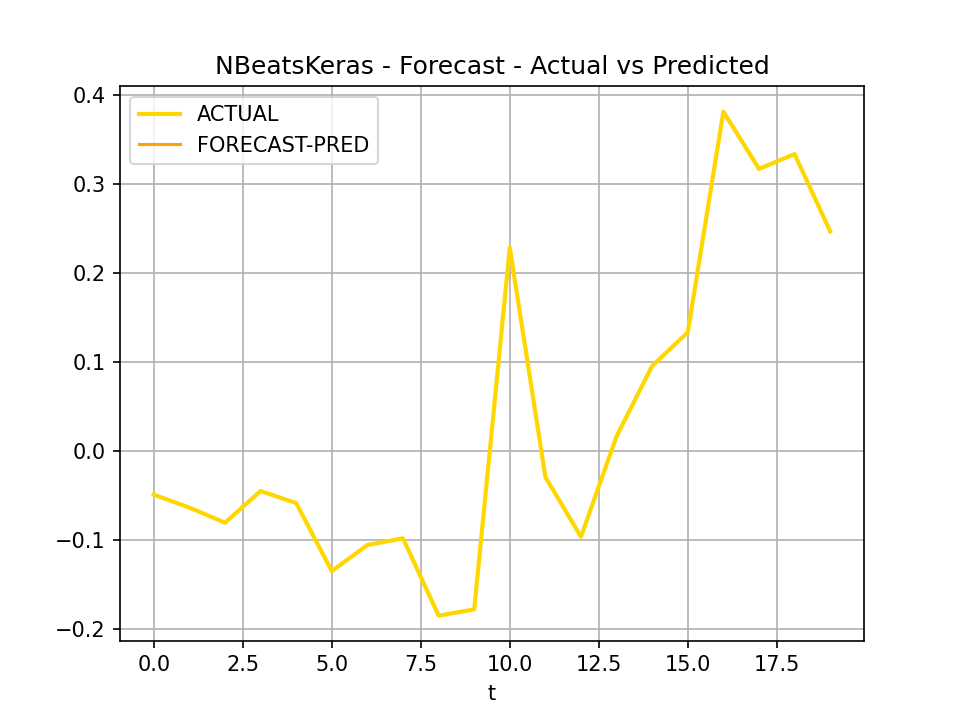

In [56]:
def plot(target, generic_predictions, interpretable_predictions, backend_name):
    plt.figure()
    plt.plot(target, color='gold', linewidth=2)
    #plt.plot(interpretable_predictions + generic_predictions, color='r', linewidth=2)
    plt.plot(interpretable_predictions, color='orange')
    #plt.plot(generic_predictions, color='green')
    plt.grid()
    plt.legend(['ACTUAL', 'FORECAST-PRED', 'FORECAST-I', 'FORECAST-G'])
    plt.xlabel('t')
    plt.title(f'{backend_name} - Forecast - Actual vs Predicted')
    plt.draw()

sample_idx = 1050
sample_x = x_test[sample_idx:sample_idx + 1]
sample_y = y_test[sample_idx]
#sample_x = x_train[sample_idx:sample_idx + 1]
#sample_y = y_train[sample_idx]
model.predict(sample_x)  # load intermediary outputs into our model object.
# NOTE: g_pred + i_pred = pred.
g_pred, i_pred, outputs = model.get_generic_and_interpretable_outputs()
plot(target=sample_y, generic_predictions=g_pred, interpretable_predictions=i_pred, backend_name=backend_name)
#subplots(outputs, backend_name)
plt.show()

In [ ]:
num_samples, time_steps, input_dim, output_dim = 50_000, 10, 1, 1

# This example is for both Keras and Pytorch. In practice, choose the one you prefer.
for BackendType in [NBeatsKeras,]:
    # NOTE: If you choose the Keras backend with input_dim>1, you have 
    # to set the value here too (in the constructor).
    backend = BackendType(
        backcast_length=time_steps, forecast_length=output_dim,
        stack_types=(NBeatsKeras.GENERIC_BLOCK, NBeatsKeras.GENERIC_BLOCK),
        nb_blocks_per_stack=2, thetas_dim=(4, 4), share_weights_in_stack=True,
        hidden_layer_units=64
    )

    # Definition of the objective function and the optimizer.
    backend.compile(loss='mae', optimizer='adam')

    data = st_all['Baro'][0].data
    # data backcast/forecast generation.
    x, y = [], []
    for epoch in range(backcast_length, len(milk) - forecast_length):
        x.append(data[epoch - backcast_length:epoch])
        y.append(data[epoch:epoch + forecast_length])
    x = np.array(x)
    y = np.array(y)

    # split train/test.
    c = int(len(x) * 0.8)
    x_train, y_train = x[:c], y[:c]
    x_test, y_test = x[c:], y[c:]

    # normalization.
    norm_constant = np.max(x_train)
    x_train, y_train = x_train / norm_constant, y_train / norm_constant
    x_test, y_test = x_test / norm_constant, y_test / norm_constant
    
    test_size = len(x_test)
    
    # Train the model.
    print('Training...')
    backend.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=128)

    # Save the model for later.
    backend.save('n_beats_model.h5')

    # Predict on the testing set (forecast).
    predictions_forecast = backend.predict(x_test)
    np.testing.assert_equal(predictions_forecast.shape, (test_size, backend.forecast_length, output_dim))

    # Predict on the testing set (backcast).
    predictions_backcast = backend.predict(x_test, return_backcast=True)
    np.testing.assert_equal(predictions_backcast.shape, (test_size, backend.backcast_length, output_dim))

    # Load the model.
    model_2 = BackendType.load('n_beats_model.h5')

    np.testing.assert_almost_equal(predictions_forecast, model_2.predict(x_test))

In [6]:
x_train.shape

(45000, 10, 1)